<a href="https://colab.research.google.com/github/DorcasO/DorcasO/blob/main/Wasteclassifier_MobileNetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Path to the dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/recycling waste'

Waste Classification Project

#Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image

##Load dataset

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(128, 128),     # Resize all images to 128x128
    batch_size=32,             # Load in batches
    label_mode='int',          # Options: 'int', 'categorical', or 'binary'
    shuffle=True
)

Found 8371 files belonging to 9 classes.


In [4]:
# View class names
print("Class names:", dataset.class_names)

Class names: ['batteries', 'clothes', 'e-waste', 'glass', 'light blubs', 'metal', 'organic', 'paper', 'plastic']


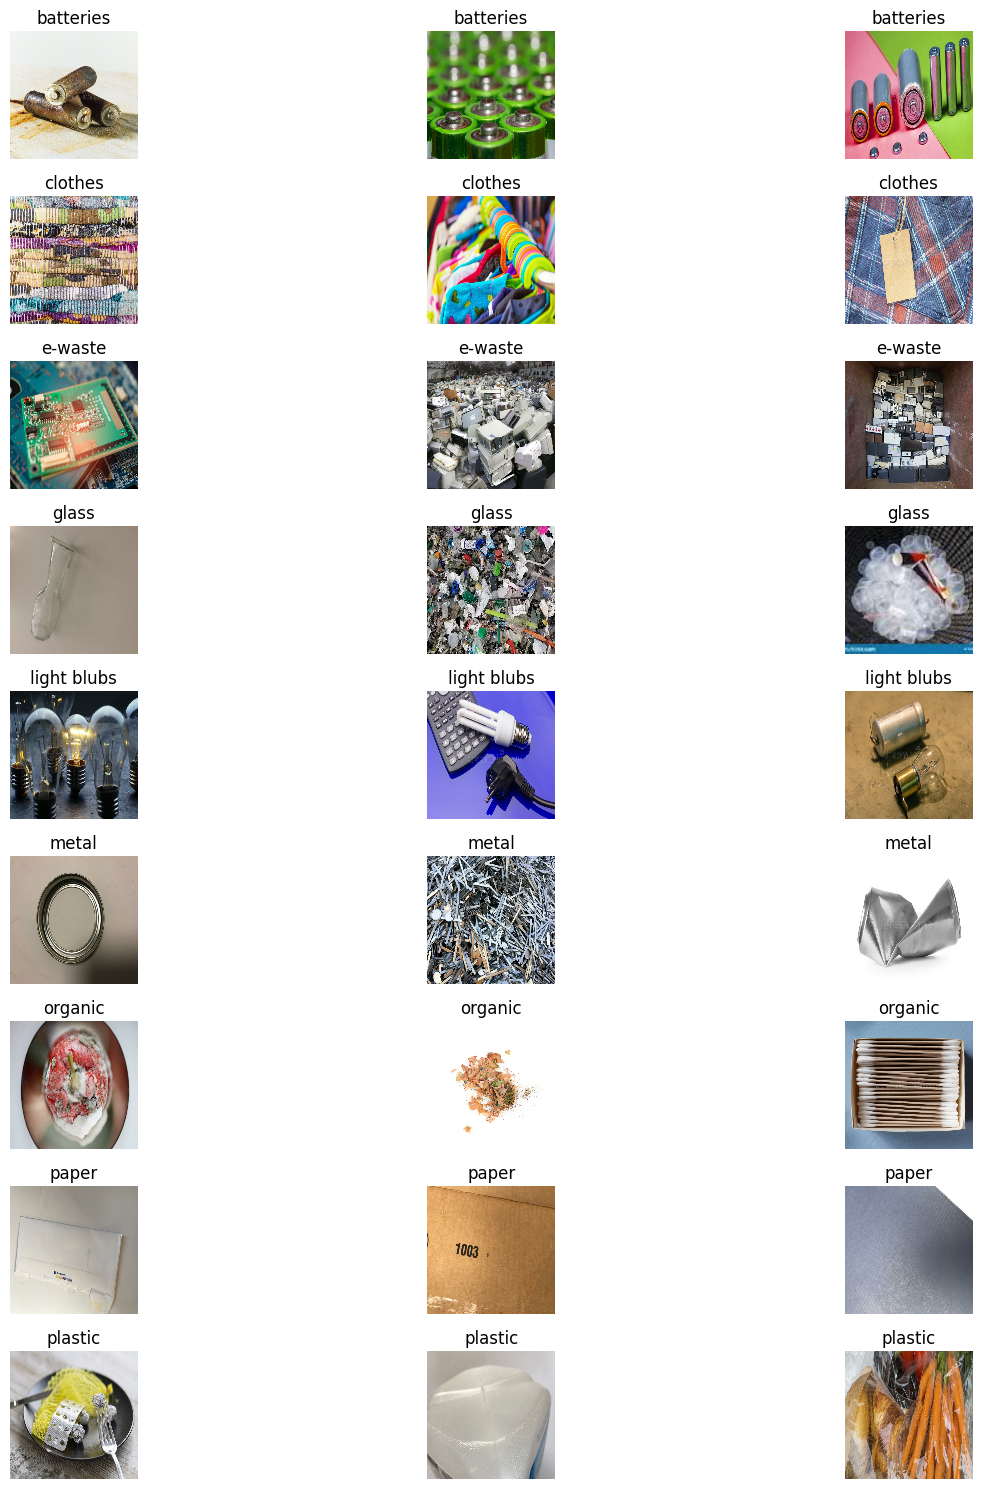

In [5]:
# Attempt to view the content of each class name

# Get class names
class_names = dataset.class_names

# Build a dictionary to collect samples for each class
samples_per_class = {class_name: [] for class_name in class_names}

# Iterate through dataset and store one image per class
for images, labels in dataset:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if len(samples_per_class[class_name]) < 3:  # Limit to 3 per class
            samples_per_class[class_name].append(img.numpy())
    if all(len(samples) >= 3 for samples in samples_per_class.values()):
        break

# Plot 3 images per class
plt.figure(figsize=(15, 15))
i = 1
for class_name, images in samples_per_class.items():
    for img in images:
        ax = plt.subplot(9, 3, i)
        plt.imshow(img.astype("uint8"))
        plt.title(class_name)
        plt.axis("off")
        i += 1

plt.tight_layout()
plt.show()

In [6]:
# List to hold data
data = []

# Loop through class folders
for class_name in sorted(os.listdir(dataset_path)):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            if os.path.isfile(file_path):
                data.append({
                    'file_path': file_path,
                    'label': class_name
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Preview the DataFrame
print(df.head())

                                           file_path      label
0  /content/drive/MyDrive/Colab Notebooks/recycli...  batteries
1  /content/drive/MyDrive/Colab Notebooks/recycli...  batteries
2  /content/drive/MyDrive/Colab Notebooks/recycli...  batteries
3  /content/drive/MyDrive/Colab Notebooks/recycli...  batteries
4  /content/drive/MyDrive/Colab Notebooks/recycli...  batteries


In [7]:
# Data Cleaning bits

valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
bad_files = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            ext = os.path.splitext(fname)[1].lower()

            if ext not in valid_extensions:
                bad_files.append((fpath, 'Invalid extension'))
                continue

            try:
                raw = tf.io.read_file(fpath)
                # Use decode_image which works for any format
                _ = tf.image.decode_image(raw)
            except Exception as e:
                bad_files.append((fpath, str(e)))

print(f"Found {len(bad_files)} bad files")
for f, reason in bad_files:
    print(f"\n⚠️ {f} — {reason}")


Found 1 bad files

⚠️ /content/drive/MyDrive/Colab Notebooks/recycling waste/light blubs/heritage-blog36.jpg — {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


In [8]:
# Filter out rows containing the bad file - 'heritage-blog36.jpg'
df_filtered = df[df['file_path'].str.contains('heritage-blog36.jpg', na=False) == False]

# Save the updated CSV
df_filtered.to_csv('recycling_dataset.csv', index=False)

print("Row(s) with 'heritage-blog36.jpg' removed.")

Row(s) with 'heritage-blog36.jpg' removed.


In [9]:
# Save to CSV
df.to_csv('recycling_dataset.csv', index=False)

<ipython-input-10-c17b2b1e43f8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='label', data=label_counts, palette='viridis')


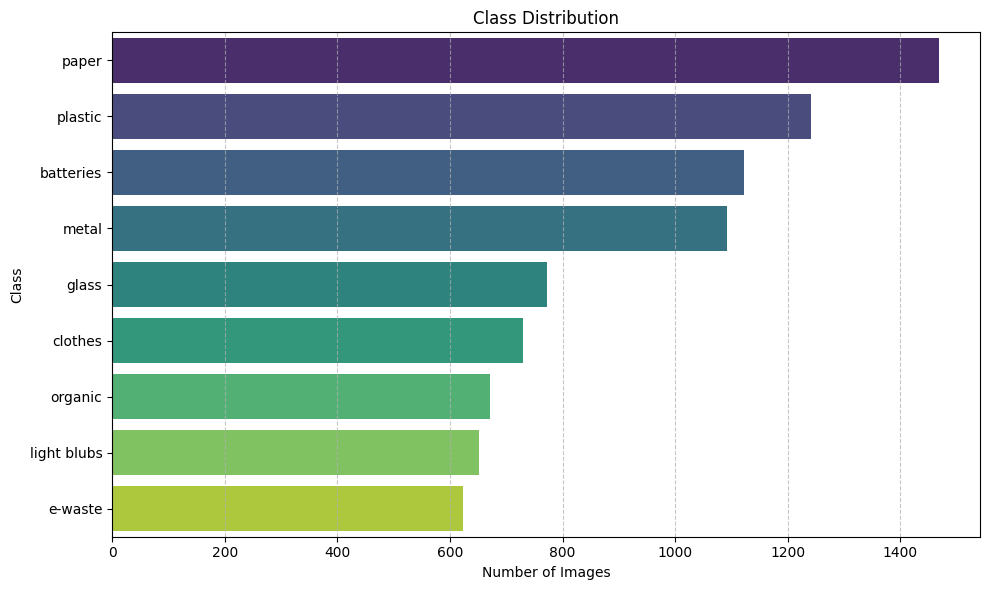

In [10]:

label_counts = df['label'].value_counts().to_frame().reset_index()
label_counts.columns = ['label', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='label', data=label_counts, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Building Image Classification Model Using MobileNetV2

In [11]:
# Reloading the filtered dataset
df = pd.read_csv('recycling_dataset.csv')
df.head()

,file_path,label
0,/content/drive/MyDrive/Colab Notebooks/recycli...,batteries
1,/content/drive/MyDrive/Colab Notebooks/recycli...,batteries
2,/content/drive/MyDrive/Colab Notebooks/recycli...,batteries
3,/content/drive/MyDrive/Colab Notebooks/recycli...,batteries
4,/content/drive/MyDrive/Colab Notebooks/recycli...,batteries


In [12]:
# regenerating the file_paths and labels from the filtered DataFrame
file_paths = df['file_path'].tolist()
labels = df['label'].tolist()

# Encode class labels
label_names = sorted(df['label'].unique())
label_to_index = {name: i for i, name in enumerate(label_names)} #df['label_index'] = df['label'].map(label_to_index)

print("Labels:", label_to_index)

# Get lists of paths and labels
#file_paths = df['file_path'].tolist()
#labels = df['label'].tolist()

# Check lengths
print("Total rows:", len(df))
print("Non-null file paths:", df['file_path'].notnull().sum())
print("Non-null labels:", df['label'].notnull().sum())

Labels: {'batteries': 0, 'clothes': 1, 'e-waste': 2, 'glass': 3, 'light blubs': 4, 'metal': 5, 'organic': 6, 'paper': 7, 'plastic': 8}
Total rows: 8371
Non-null file paths: 8371
Non-null labels: 8371


In [13]:
# Drop rows where either file_path or label is missing
df = df.dropna(subset=['file_path', 'label'])

# Now extract
file_paths = df['file_path'].tolist()
labels = df['label'].tolist()

In [14]:
# Applying data augumentation
from tensorflow.keras import layers


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])


In [15]:
from sklearn.preprocessing import LabelEncoder
# Encode string labels into integers
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# To map back later
class_names = le.classes_
num_classes = len(class_names)

In [16]:

valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

file_path = [p for p in file_path if os.path.splitext(p)[1].lower() in valid_extensions]


def load_image(file_path, label):
    image = tf.io.read_file(file_path)
    try:
        image = tf.io.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.resize(image, [224, 224])
    except tf.errors.InvalidArgumentError:
        print(f"Invalid image: {path.numpy().decode()}")
        image = tf.zeros([224, 224, 3])  # Placeholder if needed
    return image, label



from PIL import Image

for path in file_paths:
    try:
        img = Image.open(path)
        img.verify()  # Will throw exception if corrupt
    except Exception as e:
        print(f"Corrupt or invalid image: {path} — {e}")

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np


In [18]:
# Encode string labels into integers
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
class_names = le.classes_
num_classes = len(class_names)

In [19]:
# Safe image decoder
def safe_decode_image(file_path):
    try:
        image = tf.io.read_file(file_path)
        image = tf.io.decode_image(image, channels=3, expand_animations=False)
        image.set_shape([None, None, 3])
        image = tf.image.resize(image, [128, 128])
        image = image / 255.0
        return image
    except:
        # Return a black dummy image if decode fails
        return tf.zeros([128, 128, 3])

#Use py_function for deccoding in Dataset pipeline


In [20]:
def load_image_tf(file_path, label):
    image = tf.py_function(safe_decode_image, [file_path], tf.float32)
    image.set_shape([128, 128, 3])  # Ensure shape is known
    return image, label


#Augmentation wrapper

In [21]:
def load_image_with_aug(file_path, label):
    image, label = load_image_tf(file_path, label)
    image = data_augmentation(image)
    return image, label

In [22]:
# Train-validation split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)

# Build datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)) \
    .map(load_image_with_aug, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)) \
    .map(load_image_tf, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(32).prefetch(tf.data.AUTOTUNE)

# Build model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile and train
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 196s 899ms/step - accuracy: 0.2909 - loss: 2.3876 - val_accuracy: 0.6066 - val_loss: 1.1799
Epoch 2/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 198s 884ms/step - accuracy: 0.4918 - loss: 1.5733 - val_accuracy: 0.6418 - val_loss: 1.0643
Epoch 3/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 201s 880ms/step - accuracy: 0.5519 - loss: 1.3636 - val_accuracy: 0.6597 - val_loss: 1.0339
Epoch 4/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 185s 878ms/step - accuracy: 0.5838 - loss: 1.2692 - val_accuracy: 0.6722 - val_loss: 1.0008
Epoch 5/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 184s 876ms/step - accuracy: 0.5877 - loss: 1.2425 - val_accuracy: 0.6878 - val_loss: 0.9679


Training loss is decreasing steadily which shows that the model is learning well.

Validation accuracy improves from 60% → 69% meaning a strong positive trend.

Validation loss steadily decreases, suggesting no overfitting yet.

#Fine Tuning

In [23]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.5115 - loss: 1.5591 - val_accuracy: 0.6042 - val_loss: 2.1724
Epoch 2/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.6527 - loss: 1.0504 - val_accuracy: 0.5224 - val_loss: 3.6140
Epoch 3/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.6908 - loss: 0.9154 - val_accuracy: 0.4561 - val_loss: 3.8074
Epoch 4/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.7399 - loss: 0.7746 - val_accuracy: 0.5355 - val_loss: 3.0166
Epoch 5/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.7546 - loss: 0.7214 - val_accuracy: 0.3457 - val_loss: 4.8785


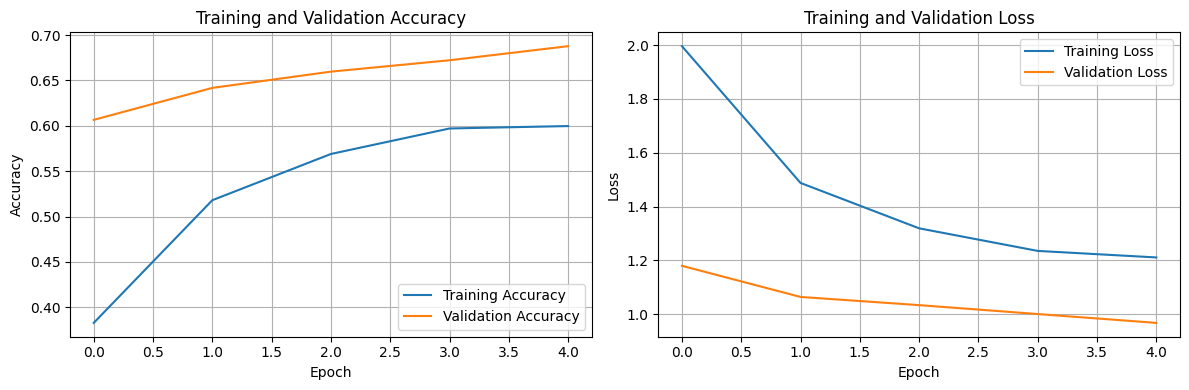

In [24]:
#Plot train history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')

#Waste_EfficientNet Model

In [29]:
%cd /content/drive/MyDrive/Colab Notebooks/recycling waste

/content/drive/.shortcut-targets-by-id/1CTvT_gnTvwlcKwJ8yz4jUOs0JYTKrplA/recycling waste


In [26]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.data import AUTOTUNE

In [31]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])